In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Function that performs one iteration of gradient descent to improve the model parameters:
def train_loop(net,loss_fn,optimizer,X_train,Y_train):
    pred = net(X_train) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step

## 2. Example: fault detection in power systems

In order to understand how a power system is functioning, we need to know 4 quantities at each bus:
* Real power injection
* Reactive power injection
* Voltage magnitude
* Voltage angle

In the event that a transmission line goes down, these quantities will change, indicating that something has happened. In this example, we consider a power system with 30 buses. 10 of the buses are equipped with [phasor measurement units](https://en.wikipedia.org/wiki/Phasor_measurement_unit) that allow us to measure the voltage angle in real time. The task is to measure the voltage angles at the ten buses and to determine whether a fault has occurred.

The data consists of observations ```X``` and labels ```Y```. Each row of ```X``` consists of a set of voltage angle measurements at the 10 buses under observation. The labels take on binary values, with 0 corresponding to no fault and 1 corresponding to the presence of a fault when the measurement was taken.

In [2]:
# Load data and split into training and test sets

XY = np.loadtxt('fault_detection_data.txt')

M = np.shape(XY)[0] # Size of dataset
n = int(.8*M) # Size of training set
X_train = XY[0:n,0:-1]
Y_train = XY[0:n,-1]
X_test = XY[n:,0:-1]
Y_test = XY[n:,-1]

First, let's train a linear classifier to detect faults based on voltage measurements.

In [3]:
# Train a linear classifier for comparison

from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train,Y_train)
Y_hat_train = logistic_classifier.predict(X_train)
print("Training error rate: ", np.sum(np.abs(Y_train-Y_hat_train))/n)
Y_hat_test = logistic_classifier.predict(X_test)
print("Test error rate: ", np.sum(np.abs(Y_test-Y_hat_test))/(M-n))

Training error rate:  0.375
Test error rate:  0.38333333333333336


The test error rate is 38%. Let's see if a neural network can do better. 

Training error rate:  0.004166666666666667
Test error rate:  0.2833333333333333


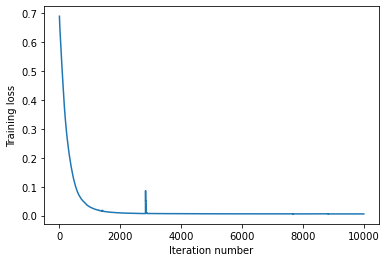

In [4]:
# Convert data from numpy array to pytorch tensor:
X_train_torch = torch.tensor(X_train).float()
Y_train_torch = torch.tensor(Y_train).float()
X_test_torch = torch.tensor(X_test).float()
Y_test_torch = torch.tensor(Y_test).float()

n_pmu = X_train.shape[1]

# Neural network class:
class fault_net(nn.Module): 
    def __init__(self,n_hidden): # Passing the parameter n_hidden to the __init__ function allows us to customize the width of the network
        super(fault_net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_pmu,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,1),
        )

    def forward(self, x): 
        return torch.sigmoid(self.model(x)) # Sigmoid clamps the output between 0 and 1 for binary classification
    
# Loss function for training:
loss_fn = nn.BCELoss() # Same loss function as for logistic regression

n_hidden = 64 # The width of each hidden layer in the network
net = fault_net(n_hidden) # Create neural network of width n_hidden

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
T = 10000
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torch,Y_train_torch.unsqueeze(1))
    
Y_hat_train = torch.round(net(X_train_torch)) # Round predictions to 0 or 1
Y_hat_test = torch.round(net(X_test_torch))
print("Training error rate: ", torch.sum(torch.abs(Y_train_torch-Y_hat_train.flatten())).item()/n)
print("Test error rate: ", torch.sum(torch.abs(Y_test_torch-Y_hat_test.flatten())).item()/(M-n))
plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

## 3. Example: state estimation

In Homework 2, we looked at the problem of estimating the voltage angles in a power grid, given line flow and bus injection measurements. Let's revisit this example using neural networks. In this problem, we will try to estimate voltage angles using only power injection measurements.

In [5]:
# Load data and split into training and test sets

XY = np.loadtxt('state_estimation_data.txt')

nbus = 30

M = np.shape(XY)[0] # Size of dataset
n = int(.8*M) # Size of training set
X_train = XY[0:n,0:nbus]
Y_train = XY[0:n,nbus:]
X_test = XY[n:,0:nbus]
Y_test = XY[n:,nbus:] # Note that there are 30 columns in X but only 29 columns in Y. That's because the voltage angle at the reference bus is always assumed to be 0, so we don't need to predict it.

First, let's check the performance of a linear model:

In [6]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
W = np.zeros((nbus,nbus-1))
b = np.zeros((nbus-1))

for i in range(nbus-1): # Get seperate column of weights for each angle measurement (skip slack bus)
    linear_regressor.fit(X_train,Y_train[:,i])
    W[:,i] = linear_regressor.coef_
    b[i] = linear_regressor.intercept_
    
Y_hat_train = X_train@W + b
Y_hat_test = X_test@W + b
print("Training error: ", np.linalg.norm(Y_hat_train-Y_train,'fro')**2/n)
print("Test error: ", np.linalg.norm(Y_hat_test-Y_test,'fro')**2/(M-n))

Training error:  0.31710994169875134
Test error:  0.8971148005248597


Now, for a neural network:

Training error:  0.08050205558538437
Test error:  15.866706848144531


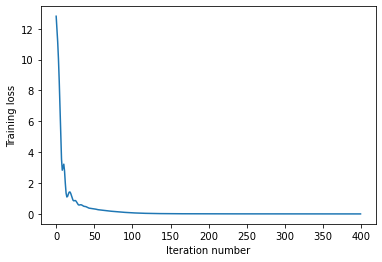

In [7]:
X_train_torch = torch.tensor(X_train).float()
Y_train_torch = torch.tensor(Y_train).float()
X_test_torch = torch.tensor(X_test).float()
Y_test_torch = torch.tensor(Y_test).float()

# Neural network class:
class state_net(nn.Module): 
    def __init__(self):
        super(state_net, self).__init__()
        n_hidden = 256
        self.model = nn.Sequential(
            nn.Linear(nbus,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,nbus-1),
        )

    def forward(self, x): 
        return self.model(x)
    
# Loss function for training:
loss_fn = nn.MSELoss()

net = state_net() # Create neural network

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
T = 400
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torch,Y_train_torch)
    
Y_hat_train = net(X_train_torch)
Y_hat_test = net(X_test_torch)
print("Training error: ", (torch.linalg.norm(Y_hat_train-Y_train_torch,ord='fro')**2/n).item())
print("Test error: ", (torch.linalg.norm(Y_hat_test-Y_test_torch,ord='fro')**2/(M-n)).item())
plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

In this example, the neural network performs substantially better on the training dataset and substantially worse on the test dataset. This is an example of _overfitting_.

# Homework questions

## Problem 1: Hyperparameter selection

Modify the example code from the fault detection problem to include a hyperparameter tuning routine. Your code should:
* Randomly generate values for ```n_hidden``` (the width of each hidden layer in the neural network) and ```lr``` (learning rate)
* Create a network of width ```n_hidden``` and an optimizer with learning rate ```lr```
* Train the network and record the hyperparemeters and the test error
* Repeat

Plot the test error vs. iteration number. Also plot the best test error seen up to that point in the hyperparemeter training process vs. iteration number.

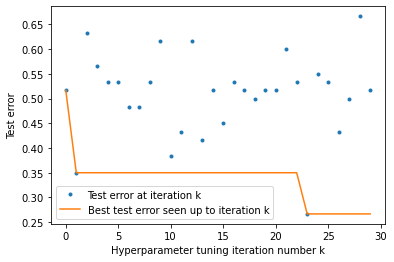

In [15]:
# Load data and split into training and test sets

XY = np.loadtxt('fault_detection_data.txt')
M = np.shape(XY)[0] # Size of dataset
n = int(.8*M) # Size of training set
X_train = XY[0:n,0:-1]
Y_train = XY[0:n,-1]
X_test = XY[n:,0:-1]
Y_test = XY[n:,-1]
X_train_torch = torch.tensor(X_train).float()
Y_train_torch = torch.tensor(Y_train).float()
X_test_torch = torch.tensor(X_test).float()
Y_test_torch = torch.tensor(Y_test).float()

hparams = [] # Create empty list to store results
test_results = []
loss_fn = nn.BCELoss() # Loss function
K = 30
# Hyperparameter selection loop:
for i in range(K):
    
    # Generate hyperparameters:
    n_hidden = int(2**(torch.rand((1))*8+2)) # Randomly choose width of neural network between 2^2 and 2^10
    lr = int(10**(torch.rand((1))*3-5))# Randomly choose learning rate between 10^-5 and 10^-2
    
    net = fault_net(n_hidden) # Create neural network
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # Create optimizer
    
    # Train neural network
    T = 5000
    for t in range(T):
        train_loop(net,loss_fn,optimizer,X_train_torch,Y_train_torch.unsqueeze(1))
        
    # Test predictions
    Y_hat_test = torch.round(net(X_test_torch)) # Round predictions to 0 or 1
    test_error = torch.sum(torch.abs(Y_test_torch-Y_hat_test.flatten())).item()/(M-n) # Compute test error rate
    
    # Store results
    hparams.append([n_hidden,lr])
    test_results.append(test_error)

# Plot results:
plt.plot(test_results,'.',label = 'Validation error')
plt.plot([np.min(test_results[0:k+1]) for k in range(K)])
plt.xlabel('Hyperparameter tuning iteration number k')
plt.ylabel('Test error')
plt.legend(['Test error at iteration k','Best test error seen up to iteration k']);

## Problem 2: Stochastic gradient descent

In the above examples, we trained the neural networks using gradient descent. [Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD) is a different algorithm for optimizing the parameters of a neural network. In SGD, we only consider one or a few training samples per iteration, instead of using the entire training dataset. By considering only a few data points at a time, the algorithm will take a less direct path towards the optimum. However, the approach is popular because it is faster to execute each training iteration.

For this problem, modify the example code from the state estimation problem to implement SGD. For each iteration, the function ```train_loop``` should:
* Randomly select a subset of the rows of ```X_train``` and ```Y_train``` (called a "minibatch")
    * Hint: use ```torch.randint``` to randomly generate row numbers.
* Use the neural network to make predictions on the minibatch
* Evalutate the loss associated with these predictions
* Take a step in the direction of the gradient of the minibatch loss

Plot the training loss as a function of the iteration number. How do the batch size and learning rate affect the results?

lr = 1e-05,batch=1:
Training error:  1.0784780979156494
Test error:  11.452284812927246


lr = 1e-05,batch=50:
Training error:  0.02133234590291977
Test error:  11.918853759765625


lr = 1e-05,batch=200:
Training error:  0.012205682694911957
Test error:  11.897459983825684


lr = 0.0001,batch=1:
Training error:  0.6689047813415527
Test error:  13.294212341308594


lr = 0.0001,batch=50:
Training error:  0.0018636476015672088
Test error:  11.134909629821777


lr = 0.0001,batch=200:
Training error:  0.00020974723156541586
Test error:  11.111974716186523


lr = 0.001,batch=1:
Training error:  0.5207644104957581
Test error:  10.366394996643066


lr = 0.001,batch=50:
Training error:  0.0003750171745195985
Test error:  11.389153480529785


lr = 0.001,batch=200:
Training error:  2.15255276998505e-05
Test error:  11.394294738769531




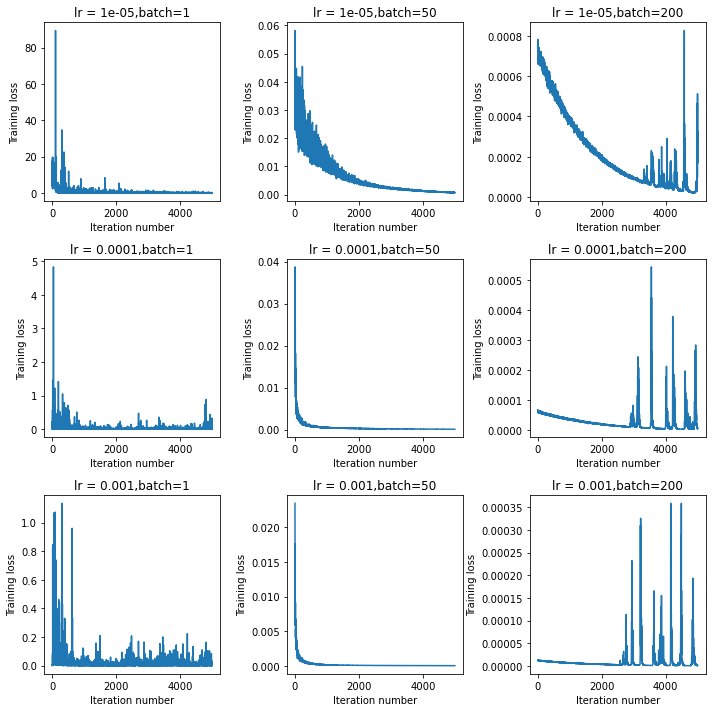

In [55]:
# Load data and split into training and test sets

XY = np.loadtxt('state_estimation_data.txt')

nbus = 30

M = np.shape(XY)[0] # Size of dataset
n = int(.8*M) # Size of training set
X_train = XY[0:n,0:nbus]
Y_train = XY[0:n,nbus:]
X_test = XY[n:,0:nbus]
Y_test = XY[n:,nbus:] # Note that there are 30 columns in X but only 29 columns in Y. That's because the voltage angle at the reference bus is always assumed to be 0, so we don't need to predict it.
X_train_torch = torch.tensor(X_train).float()
Y_train_torch = torch.tensor(Y_train).float()
X_test_torch = torch.tensor(X_test).float()
Y_test_torch = torch.tensor(Y_test).float()

def train_loop_SGD(net,loss_fn,optimizer,X_train,Y_train,batch):
    rows = torch.randint(0,n,(batch,))
    X_train_batch = X_train[rows,:]
    Y_train_batch = Y_train[rows,:]
    pred = net(X_train_batch) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train_batch) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step
    
# Loss function for training:
loss_fn = nn.MSELoss()

net = state_net() # Create neural network

# Create an 'optimizer' object for training:
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

i = 1
T = 5000
plt.figure(figsize=(10,10))
for lr in [1e-5,1e-4,1e-3]:
    for batch in [1,50,200]:
        loss_traj = []
        for t in range(T):
            train_loop_SGD(net,loss_fn,optimizer,X_train_torch,Y_train_torch,batch)

        Y_hat_train = net(X_train_torch)
        Y_hat_test = net(X_test_torch)
        print(f'lr = {lr},batch={batch}:')
        print("Training error: ", (torch.linalg.norm(Y_hat_train-Y_train_torch,ord='fro')**2/n).item())
        print("Test error: ", (torch.linalg.norm(Y_hat_test-Y_test_torch,ord='fro')**2/(M-n)).item())
        print('\n')
        
        plt.subplot(3,3,i)
        plt.plot(loss_traj)
        plt.xlabel('Iteration number')
        plt.ylabel('Training loss')
        plt.title(f'lr = {lr},batch={batch}')
        i += 1
plt.tight_layout()

In this case, larger batches and step sizes lead to lower training error, although this observation will not necessarily hold for other datasets/learning tasks. In general, smaller batch sizes and larger learning rates will lead to training trajectories that are more noisy. This noise can help to avoid saddle points and local minima, leading to better solutions, but if there is too much noise then the training process might never converge.